# Q2SLS Function Testing

This notebook is an attempt to explore some of the properties of the Q2SLS approach that is implemented in `quadratic2SLS.py`. The setting is one in which the true DGP is quadratic in the endogenous variable. We construct the following monte carlo simulation:

### True Data Generating Process:
$$
\begin{align*}
\begin{pmatrix}
  \mathrm{X}_{1, i}\\
  \mathrm{X}_{2, i}\\
  \mathrm{X}_{3, i}\\
  \mathrm{X}_{4, i}\\
  \mathrm{Z}_{1, i}\\
  \mathrm{Z}_{2, i}
\end{pmatrix} \ &\sim \ N
\begin{bmatrix}
\begin{pmatrix}
  3\\
  -1.5\\
  1.1\\
  2.3\\
  -1\\
  3
\end{pmatrix} \ , \
\begin{pmatrix}
    1 & 0 & 0 & 0.75 & 0.8 & 0.6 \\
    0 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 0 & 0 \\
    0.75 & 0 & 0 & 1 & 0 & 0 \\
    0.8 & 0 & 0 & 0 & 1 & 0 \\
    0.6 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{bmatrix} \\
\\
\varepsilon_i \ &\sim  \ N(0, 1) \\
\\
\mathrm{Y}_i &= 1.5 + 2.5 \cdot \mathrm{X}_{1, i} - 0.7 \cdot \mathrm{X}_{1, i}^2 + 2 \cdot \mathrm{X}_{2, i} + 3 \cdot \mathrm{X}_{3, i} + 2 \cdot \mathrm{X}_{4, i} + \varepsilon_i
\end{align*}
$$

### Estimation Procedure:
Let us assume that we observe n observations of $[\mathrm{X}_1, \ \mathrm{X}_2, \ \mathrm{X}_3, \ \mathrm{Z}_1, \ \mathrm{Z}_2]$. In this case it is clear that $\mathrm{X}_1$ will be endogenous in an estimation of the DGP ($\mathrm{Cov}[\mathrm{X}_{1, i}, \ \mathrm{X}_{4, i}] \ne 0 \Rightarrow \mathrm{Cov}[\mathrm{X}_{1, i}, \ \mathrm{\varepsilon}_{i}]$). Standard 2SLS will not work in this setting becasue our right hand side endogenous variable is nonlinear. Here we use the "Q2SLS" procedure that Wooldridge suggests (Econometric Analysis of Cross Section and Panel Data, p.236-237) which uses what we call "nested generated regressors". The procedure is as follows:
* *First Stage*:
    - *Part A*: Regress the endogenous variable ($\mathrm{X}_1$) on the exogenous variables ($[1, \ \mathrm{X}_2, \ \mathrm{X}_3]$) and instruments ($[\mathrm{Z}_1, \ \mathrm{Z}_2]$). Retain the fitted values ($\hat{\mathrm{X}}_1$).
    - *Part B*: Regress the endogenous variable squared ($\mathrm{X}_1^2$) on the exogenous variables ($[1, \ \mathrm{X}_2, \ \mathrm{X}_3]$), instruments ($[\mathrm{Z}_1, \ \mathrm{Z}_2]$), and the fitted values from Part A squared ($\hat{\mathrm{X}}_1^2$). Retain the fitted values ($\hat{\mathrm{X}_1^2}$).
* *Second Stage*: Regress Y on the exogenous variables ($[1, \ \mathrm{X}_2, \ \mathrm{X}_3]$), instruments ($[\mathrm{Z}_1, \ \mathrm{Z}_2]$), and first stage fitted values ($[\hat{\mathrm{X}}_1, \ \hat{\mathrm{X}_1^2}]$).

### Simulation Analysis:
We run two simulations, a Strong Instruments setting (with the covariance matrix above), and a Weak Instruments setting (where the covariance between $\mathrm{X}_1$ and the instruments is 0.25 and 0.2). In each simulation we bootstrap with 100 iterations, in each iteration drawing a new sample of size n = 500,000 from the true DGP.  

We then return a table comparing the average coefficient estimates across the bootstrap iterations to the true coefficient values.  

We also plot the distributions of each coefficient across the bootstrap iterations and the convergence path of the coefficient on $\hat{\mathrm{X}}_1$ (a running average).

In [18]:
# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

import quadratic2SLS as q2sls
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

In [44]:
## ~~~~~ Functions ~~~~~ ##

## Coefficient Results Table ##
def results_df(results_obj, true_coeffs):
    '''Returns summary of coefficient results compared to true coeff.s'''
    
    coeff_estms = pd.DataFrame([results_obj.beta_hat_boots.mean(axis=0), results_obj.result2.params]).transpose()
    coeff_estms.columns = ['Bootstrapped', 'Full_Sample']
    coeff_estms['True_Coeffs'] = true_coeffs
    return coeff_estms

def results_df2(big_bootstrap_res, small_bootstrap_res, true_coeffs):
    '''Returns summary of coefficient results compared to true coeff.s'''
    
    coeff_estms = pd.DataFrame([true_coeffs, list(big_bootstrap_res.mean(axis=0)), list(small_bootstrap_res.mean(axis=0))]).transpose()
    coeff_estms.columns = ['True_Coeffs', 'Full_Sample_Bootstrap', 'Bootstrap_Sample_Bootstrap']
    coeff_estms = coeff_estms.set_index([['const', 'endog_hat', 'endog_sq_hat', 'X2', 'X3']])
    return coeff_estms

def results_df3(big_bootstrap_res, true_coeffs):
    '''Returns summary of coefficient results compared to true coeff.s'''
    
    coeff_estms = pd.DataFrame([true_coeffs, list(big_bootstrap_res.mean(axis=0))]).transpose()
    coeff_estms.columns = ['True_Coeffs', 'Full_Sample_Bootstrap']
    coeff_estms = coeff_estms.set_index([['const', 'endog_hat', 'endog_sq_hat', 'X2', 'X3']])
    return coeff_estms

## Coefficient Estimate Distributions ##
def custom_dist_plots(results_obj, true_coeffs):
    coeff_estms = results_df(results_obj, true_coeffs)
    
    plt.figure(figsize=(16, 16))
    sns.set(style="whitegrid", palette="muted", color_codes=True)

    plt.subplots_adjust(top=0.92)
    plt.suptitle('Bootstrapped Coefficient Estimates Compared to Full Sample Estimate\nBlue: Bootstrapped Estimate\nRed: Full Sample Estimate\nBlack: True Coefficient')

    sns.despine()
    for column_index, column in enumerate(results_obj.X_hat.columns.values.tolist()):
        plt.subplot(3, 2, column_index + 1)
        sns.kdeplot(results_obj.beta_hat_boots[column])
        #plt.plot([results_obj.result2.params[column_index], results_obj.result2.params[column_index]], 
        #         [0, 500], 
        #         linewidth=1,
        #        color = 'red')
        plt.plot([coeff_estms['Full_Sample'][column_index], coeff_estms['Full_Sample'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'red')
        plt.plot([coeff_estms['True_Coeffs'][column_index], coeff_estms['True_Coeffs'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'black')
        plt.plot([coeff_estms['Bootstrapped'][column_index], coeff_estms['Bootstrapped'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'blue')

def custom_dist_plots2(big_bootstrap_res, results_table_out, add_to_title = ''):
    coeff_estms = results_table_out
    
    plt.figure(figsize=(16, 16))
    sns.set(style="whitegrid", palette="muted", color_codes=True)

    plt.subplots_adjust(top=0.92)
    plt.suptitle('Bootstrapped Full Coefficient Estimates' + str(add_to_title) + 
                 '\nBlue: Bootstrapped Full Sample Estimate\nRed: Bootstrapped Bootstrap Sample Estimate\nBlack: True Coefficient')

    sns.despine()
    for column_index, column in enumerate(coeff_estms.index.tolist()):
        plt.subplot(3, 2, column_index + 1)
        sns.kdeplot(big_bootstrap_res[:,column_index])
        #plt.plot([results_obj.result2.params[column_index], results_obj.result2.params[column_index]], 
        #         [0, 500], 
        #         linewidth=1,
        #        color = 'red')
        plt.plot([coeff_estms['Full_Sample_Bootstrap'][column_index], coeff_estms['Full_Sample_Bootstrap'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'blue')
        plt.plot([coeff_estms['True_Coeffs'][column_index], coeff_estms['True_Coeffs'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'black')
        plt.plot([coeff_estms['Bootstrap_Sample_Bootstrap'][column_index], coeff_estms['Bootstrap_Sample_Bootstrap'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'red')
        plt.title('Coefficient on:   `' + str(column) + '`')
        
        
def custom_dist_plots3(big_bootstrap_res, results_table_out, add_to_title = ''):
    coeff_estms = results_table_out
    
    plt.figure(figsize=(16, 16))
    sns.set(style="whitegrid", palette="muted", color_codes=True)

    plt.subplots_adjust(top=0.92)
    plt.suptitle('Bootstrapped Full Coefficient Estimates' + str(add_to_title) + 
                 '\nBlue: Bootstrapped Full Sample Estimate\nBlack: True Coefficient')

    sns.despine()
    for column_index, column in enumerate(coeff_estms.index.tolist()):
        plt.subplot(3, 2, column_index + 1)
        sns.kdeplot(big_bootstrap_res[:,column_index])
        #plt.plot([results_obj.result2.params[column_index], results_obj.result2.params[column_index]], 
        #         [0, 500], 
        #         linewidth=1,
        #        color = 'red')
        plt.plot([coeff_estms['Full_Sample_Bootstrap'][column_index], coeff_estms['Full_Sample_Bootstrap'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'blue')
        plt.plot([coeff_estms['True_Coeffs'][column_index], coeff_estms['True_Coeffs'][column_index]], 
                 [0, 500], 
                 linewidth=1,
                color = 'black')
        plt.title('Coefficient on:   `' + str(column) + '`')


## Coefficient Paths ##
def coeff_path_plot(results_obj, var_name, n_boot):
    cumsum_beta_hat_boots = np.cumsum(results_obj.beta_hat_boots[var_name])
    plt.title('Running Average from Bootstrap: `' + str(var_name) +'`')
    plt.xlabel('Bootstrap Iteration')
    plt.ylabel('Average of Bootstrapped Coefficients')
    sns.tsplot(cumsum_beta_hat_boots/np.arange(n_boot));
    
def coeff_path_plot2(big_bootstrap_res, var_name, var_index, n_boot):
    cumsum_beta_hat_boots = np.cumsum(big_bootstrap_res[:, var_index])
    plt.title('Running Average from Bootstrap: `' + str(var_name) +'`')
    plt.xlabel('Bootstrap Iteration')
    plt.ylabel('Average of Bootstrapped Coefficients')
    sns.tsplot(cumsum_beta_hat_boots/np.arange(n_boot));

# Strong Instruments

*Note: Ignore the `small_bootstrap` argument, it isn't used in this analysis*

In [50]:
np.random.seed(49067)

n = 500000
n_small_bootstrap = 1
n_big_bootstrap = 100

## DGP ##
# X1 is endogenous because we are going to leave X4 out as an ommitted var and cov(X1, X4) =/= 0
# Z's are the instruments we will use for X1
var_names = ['X1', 'X2', 'X3', 'X4', 'Z1', 'Z2']
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.8, 0.6],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.8, 0, 0, 0, 1, 0],
       [0.6, 0, 0, 0, 0, 1]]



### Big Bootstrap ###
full_sample_btsp_coeff  = np.zeros((n_big_bootstrap, 5))
small_btsp_avg_coeff = np.zeros((n_big_bootstrap, 5))

for BB_iter in tqdm(range(0, n_big_bootstrap)):
    ## Data Generation ##
    X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

    # Normal, mean zero errors
    epsilon = np.random.normal(0, 1, n)

    # True model:
    Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

    ## Constructing the data sets ##
    # Note: we leave out X4 as the omitted variable from which endogeneity is arising
    exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
    exogenous = sm.add_constant(exogenous)
    endogenous = pd.DataFrame({'X1' : X1})
    instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
    Y = pd.DataFrame({'Y' : Y})

    ## Estimating the models ##
    model1 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
    result1 = model1.fit(cov_type='Bootstrap', n_iter = n_small_bootstrap, progress_disable = True)

    ## Results ##
    full_sample_btsp_coeff[BB_iter] = result1.result2.params

100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


In [46]:
results_table = results_df3(full_sample_btsp_coeff, true_coeffs = [1.5, 2.5, -0.7, 2, 3])
results_table

,True_Coeffs,Full_Sample_Bootstrap
const,1.5,5.197619
endog_hat,2.5,2.801973
endog_sq_hat,-0.7,-0.700347
X2,2.0,2.000082
X3,3.0,2.999946


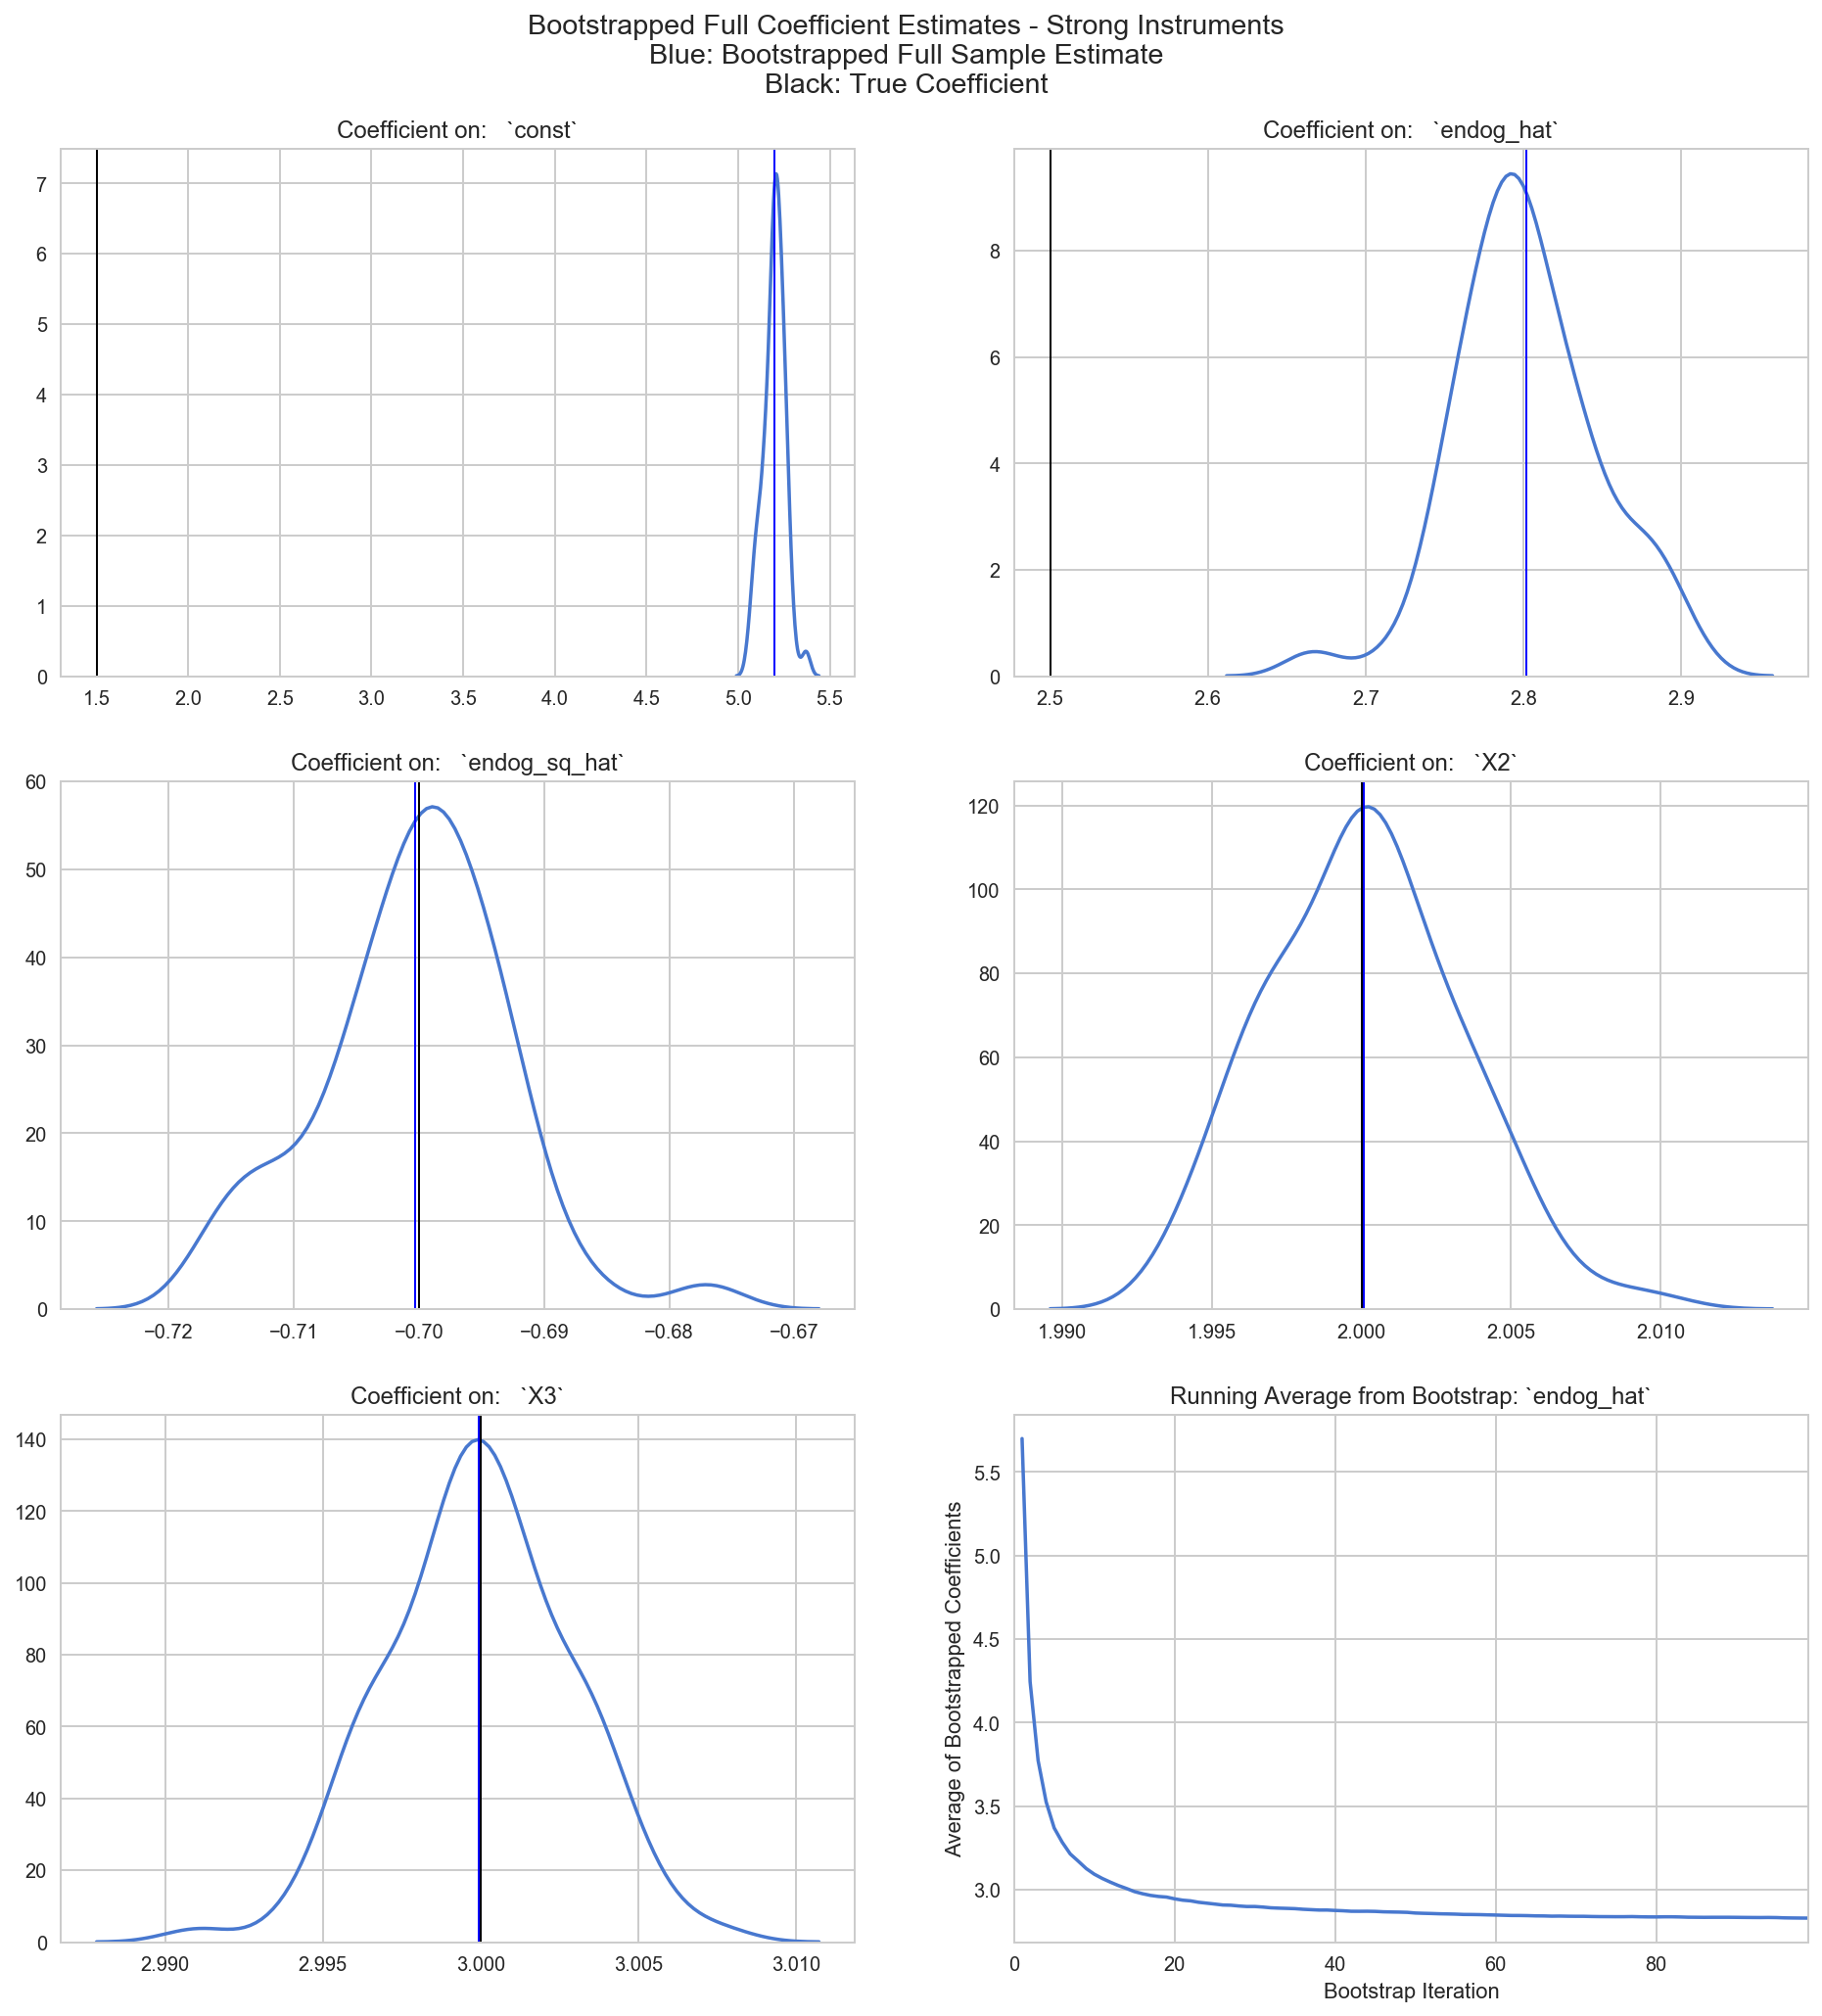

In [47]:
# Full Sample Bootstrap Distributions
custom_dist_plots3(full_sample_btsp_coeff, results_table, add_to_title=' - Strong Instruments')
# Coefficient Path
plt.subplot(3, 2, 6)
coeff_path_plot2(full_sample_btsp_coeff, 'endog_hat', 1, n_big_bootstrap)

# Weak Instruments

*Note: Ignore the `small_bootstrap` argument, it isn't used in this analysis*

In [51]:
np.random.seed(49067)

n = 500000
n_small_bootstrap = 1
n_big_bootstrap = 100

## DGP ##
# X1 is endogenous because we are going to leave X4 out as an ommitted var and cov(X1, X4) =/= 0
# Z's are the instruments we will use for X1
var_names = ['X1', 'X2', 'X3', 'X4', 'Z1', 'Z2']
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.25, 0.2],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.25, 0, 0, 0, 1, 0],
       [0.2, 0, 0, 0, 0, 1]]



### Big Bootstrap ###
full_sample_btsp_coeff2  = np.zeros((n_big_bootstrap, 5))
small_btsp_avg_coeff2 = np.zeros((n_big_bootstrap, 5))

for BB_iter in tqdm(range(0, n_big_bootstrap)):
    ## Data Generation ##
    X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

    # Normal, mean zero errors
    epsilon = np.random.normal(0, 1, n)

    # True model:
    Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

    ## Constructing the data sets ##
    # Note: we leave out X4 as the omitted variable from which endogeneity is arising
    exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
    exogenous = sm.add_constant(exogenous)
    endogenous = pd.DataFrame({'X1' : X1})
    instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
    Y = pd.DataFrame({'Y' : Y})

    ## Estimating the models ##
    model2 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
    result2 = model2.fit(cov_type='Bootstrap', n_iter = n_small_bootstrap, progress_disable = True)

    ## Results ##
    full_sample_btsp_coeff2[BB_iter] = result2.result2.params

100%|██████████| 100/100 [02:32<00:00,  1.53s/it]


In [52]:
results_table2 = results_df3(full_sample_btsp_coeff2, true_coeffs = [1.5, 2.5, -0.7, 2, 3])
results_table2

,True_Coeffs,Full_Sample_Bootstrap
const,1.5,6.022988
endog_hat,2.5,2.556635
endog_sq_hat,-0.7,-0.709311
X2,2.0,2.000097
X3,3.0,3.000150


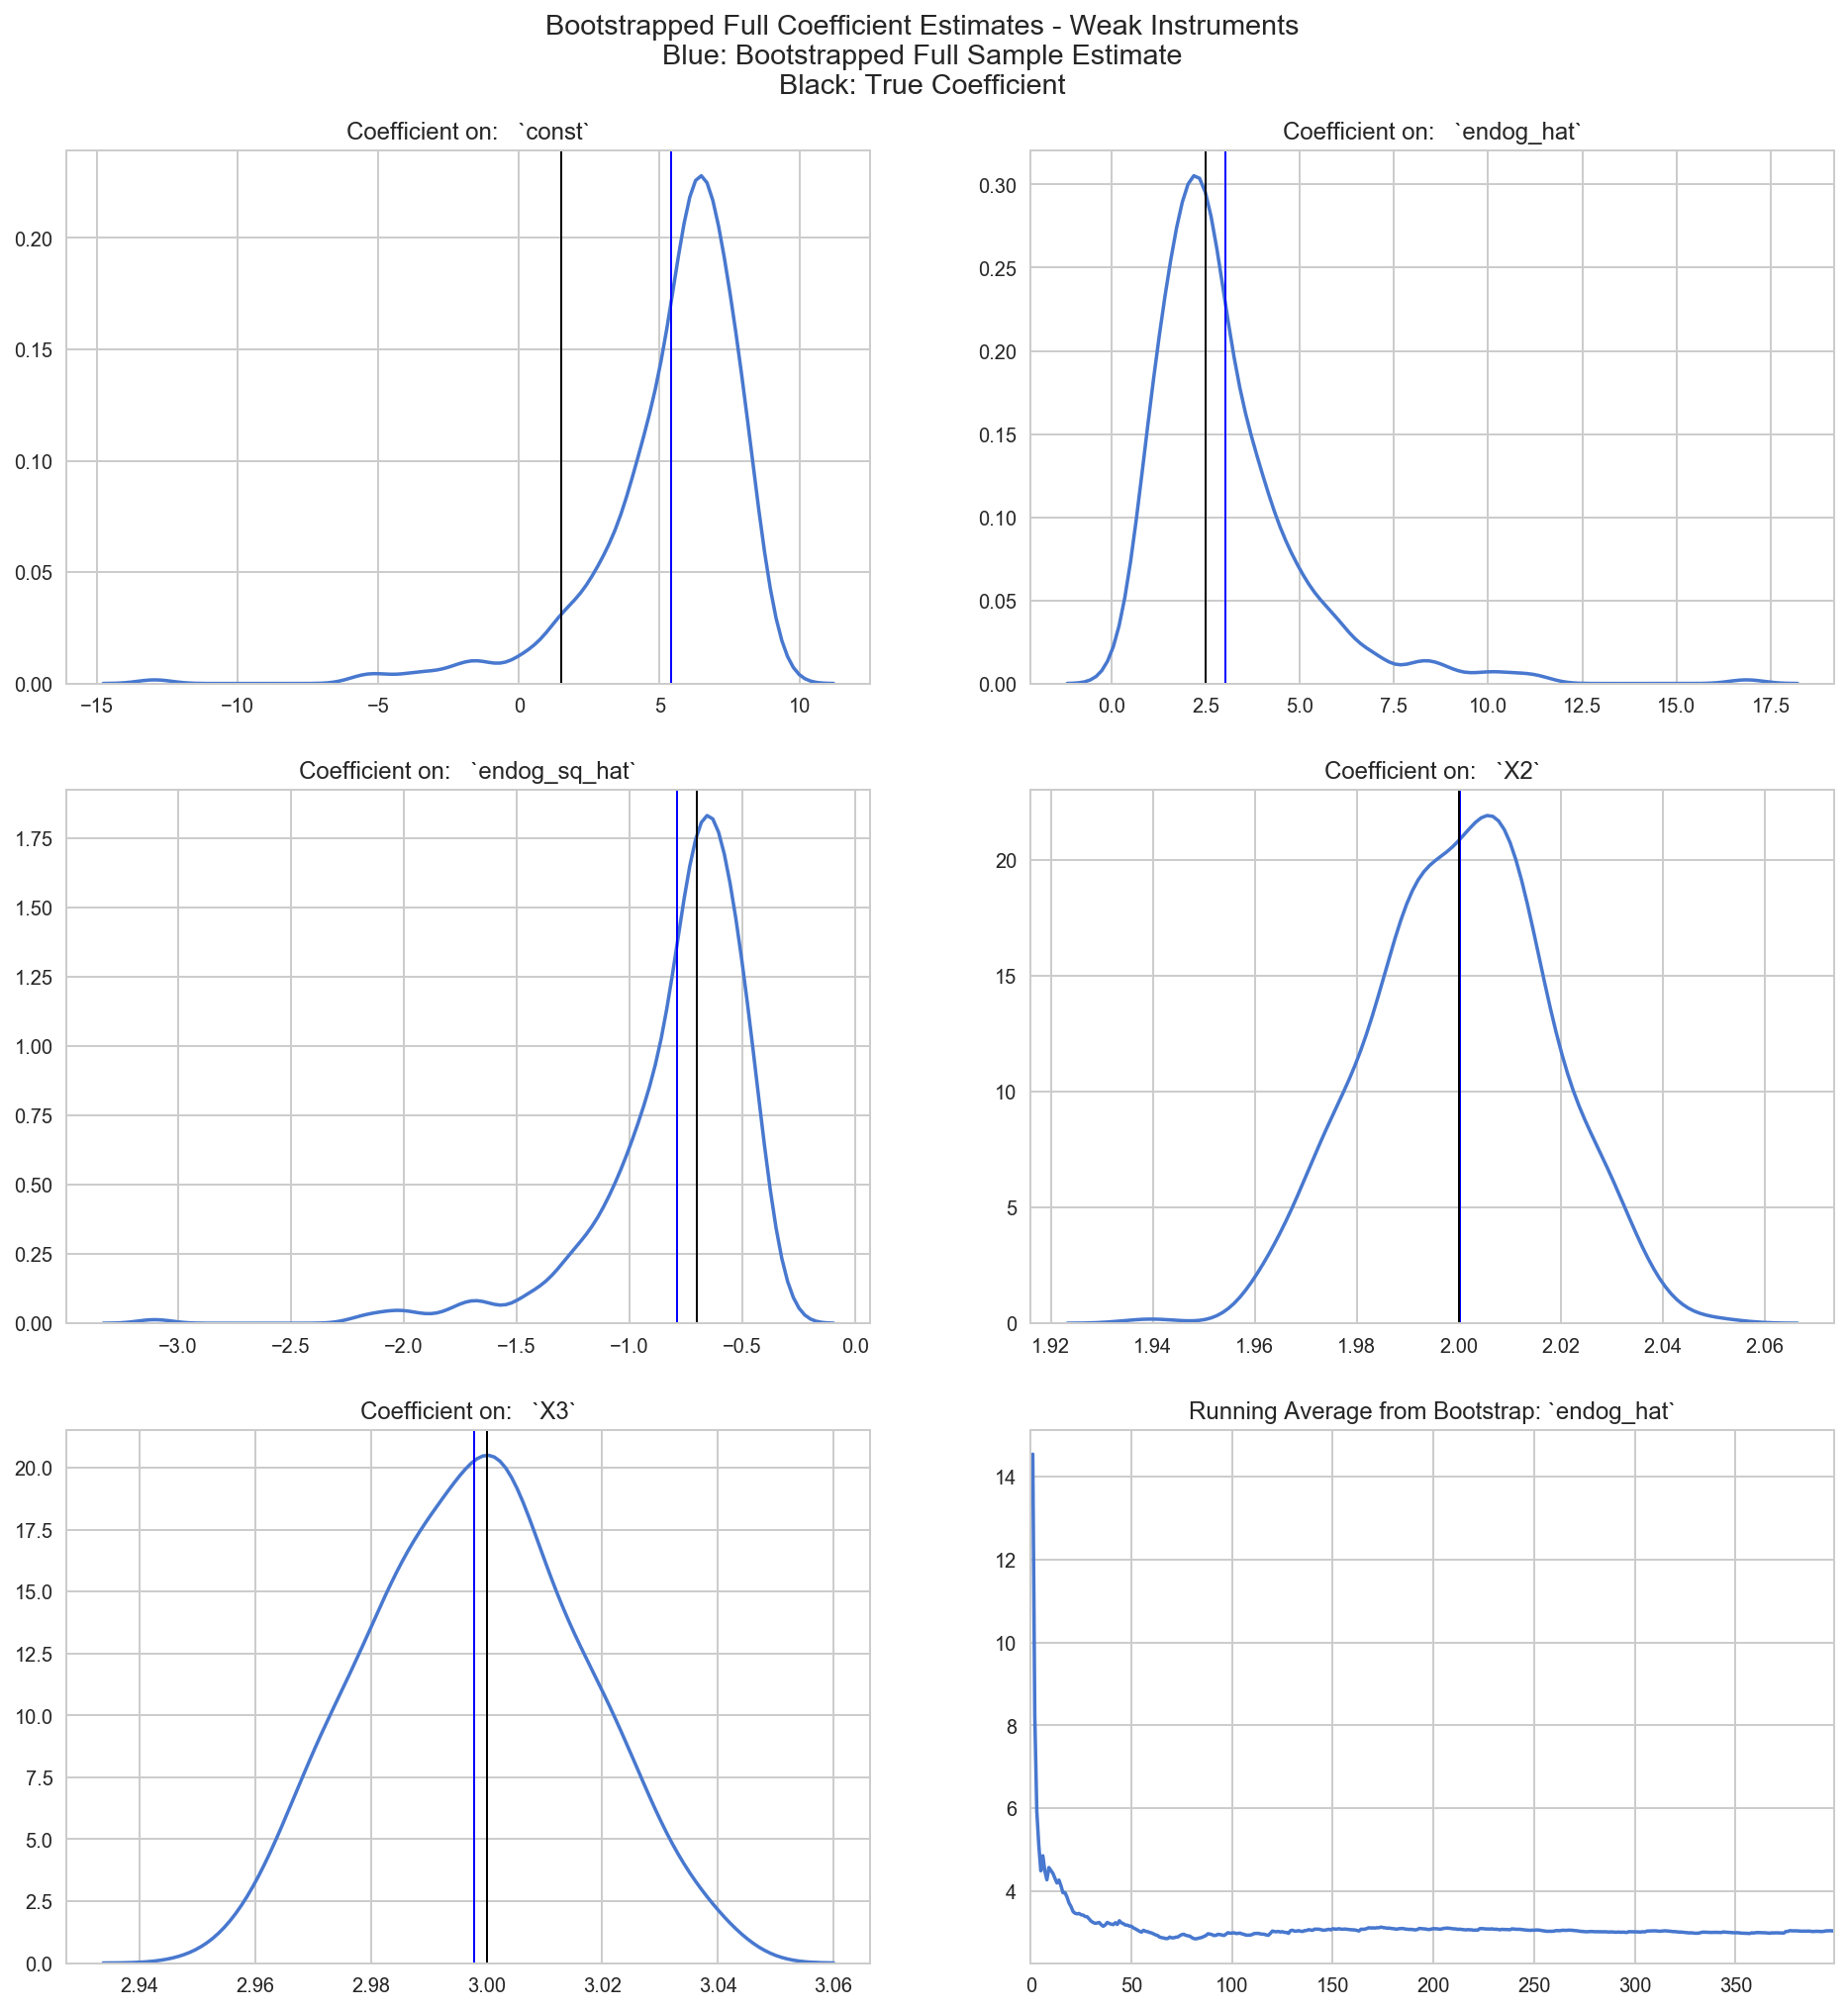

In [30]:
# Full Sample Bootstrap Distributions
custom_dist_plots3(full_sample_btsp_coeff2, results_table2, add_to_title=' - Weak Instruments')
# Coefficient Path
plt.subplot(3, 2, 6)
coeff_path_plot2(full_sample_btsp_coeff2, 'endog_hat', 1, n_big_bootstrap)